# The Constitutional Controller: Doubt-Calibrated Steering of Compliant Agents

## Setup

In [1]:
import glob
import json
from copy import deepcopy
from pathlib import Path
from pickle import dump

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.patches import Polygon
from networkx import Graph
from numpy import array, eye, float32
from PIL import Image

from promis import ConstitutionalController, ProMis, StaRMap
from promis.coco import DoubtDensity
from promis.geo import (
    CartesianCollection,
    CartesianMap,
    CartesianPolygon,
    CartesianRasterBand,
    PolarLocation,
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Make plots look nice in a paper
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

sns.set_theme(style="ticks", rc={"legend.title_fontsize": 15})  # "figure.figsize": (10, 4)
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

## Preparing the scenario

Loading the image, loading the identified foam blocks from the vision model, and rescaling everything to a common reference in millimeters.

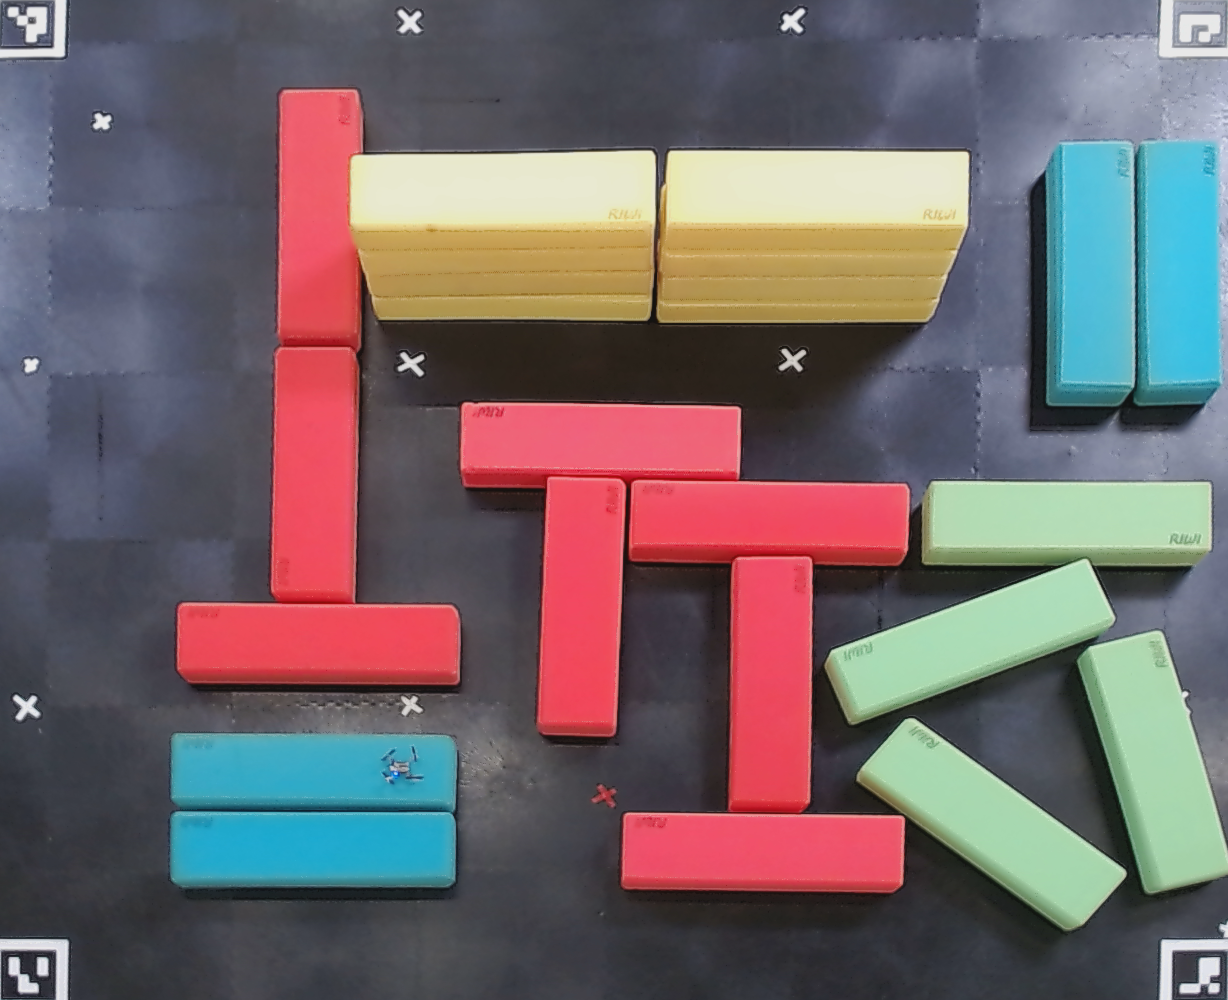

In [4]:
scene_image = Image.open("coco_linearized_image.png")
scene_image

In [5]:
boxes_df = pd.read_csv("coco_bounding_boxes.csv")
boxes_df

,x,y,width,height,area,stability_score,avg_hue,color,poly_oriented
0,857.0,718.0,268.0,213.0,23442,0.987449,60.639493,green,"[(1129, 871), (1072, 938), (850, 778), (909, 7..."
1,270.0,347.0,88.0,256.0,21633,0.983448,169.852494,red,"[(361, 347), (354, 603), (269, 603), (274, 347)]"
2,921.0,481.0,291.0,86.0,24434,0.991605,55.644512,green,"[(1212, 482), (1212, 567), (920, 565), (922, 4..."
3,824.0,560.0,290.0,165.0,22460,0.986512,63.096527,green,"[(1120, 628), (846, 728), (818, 653), (1087, 5..."
4,176.0,603.0,283.0,83.0,22956,0.984746,156.305280,red,"[(459, 604), (459, 686), (176, 684), (176, 602)]"
5,1078.0,631.0,149.0,263.0,23535,0.984483,62.889356,green,"[(1236, 874), (1144, 895), (1072, 649), (1165,..."
6,275.0,89.0,87.0,511.0,20281,0.984647,157.864947,red,"[(359, 350), (276, 344), (278, 90), (362, 88)]"
7,277.0,89.0,85.0,261.0,20277,0.985652,157.793017,red,"[(359, 350), (276, 344), (278, 90), (362, 88)]"
8,459.0,403.0,281.0,85.0,21677,0.986254,168.381510,red,"[(740, 405), (740, 478), (458, 491), (460, 401)]"
9,537.0,477.0,89.0,260.0,20830,0.985040,168.560922,red,"[(626, 478), (615, 738), (535, 734), (545, 476)]"


In [6]:
# Calculate the size of the image in millimeters
average_box_width_pixels = (277 + 281 + 245) / 3
average_box_height_pixels = (65 + 65 + 74) / 3

# True measurements in mm
box_width_mm = 800
box_height_mm = 200

# Calculate the pixel size in mm
pixel_height_mm = box_height_mm / average_box_height_pixels
pixel_width_mm = box_width_mm / average_box_width_pixels

# The image is linearized, so these two should not be too different (at most 5%)
assert abs(pixel_height_mm - pixel_width_mm) / pixel_height_mm < 0.05

# Size of the entire setup
field_width_mm = scene_image.width * pixel_width_mm
field_height_mm = scene_image.height * pixel_height_mm

(field_width_mm, field_height_mm), (pixel_height_mm, pixel_width_mm)

((3670.236612702366, 2941.1764705882356),
 (2.9411764705882355, 2.9887920298879203))

In [7]:
# Check that the aspect ratios are not too far off
(scene_image.width / scene_image.height), (field_width_mm / field_height_mm)

(1.228, 1.2478804483188044)

In [8]:
map_features = []
for index, box in boxes_df.iterrows():
    coords = array(
        json.loads(box["poly_oriented"].replace("(", "[").replace(")", "]")), dtype=float32
    )
    if coords.shape[0] != 4:
        print(f"The coordinates at index #{index} are not in the right format, skipping")
        continue

    # Rescale the coordinates from pixels to millimeters in the real world
    coords[:, 0] *= pixel_width_mm
    coords[:, 1] *= pixel_height_mm

    # Make sure that (0, 0) is the center of the cage
    coords[:, 0] -= field_width_mm / 2
    coords[:, 1] -= field_height_mm / 2
    coords[:, 1] *= -1  # Flip the y-axis to go from image to real world coordinates

    # Convert the coordinates to a CartesianPolygon
    map_features.append(CartesianPolygon.from_numpy(coords.T, location_type=box["color"]))

len(map_features), map_features[0]

(25,
 CartesianPolygon(locations=[(1539.2279052734375, -1091.1763916015625), (1368.8665771484375, -1288.2352294921875), (705.3548583984375, -817.6470947265625), (881.6934814453125, -626.4705810546875), (1539.2279052734375, -1091.1763916015625)], location_type=green, identifier=2725402352000154975))

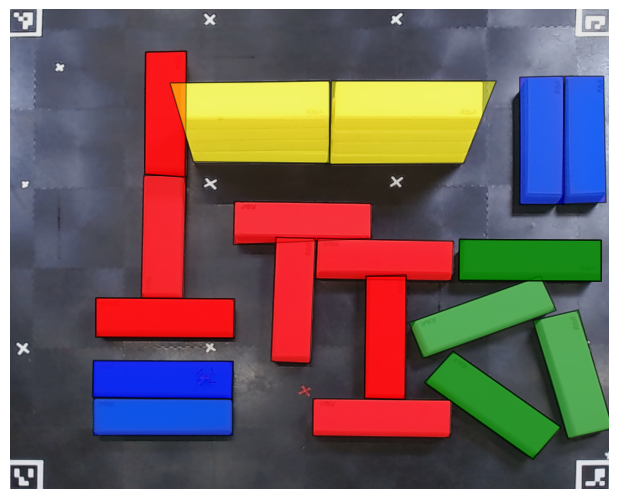

In [9]:
# Visualize the bounding boxes
plt.imshow(
    scene_image,
    extent=(-field_width_mm / 2, field_width_mm / 2, -field_height_mm / 2, field_height_mm / 2),
)
for polygon in map_features:
    plt.gca().add_patch(
        Polygon(
            [(loc.x, loc.y) for loc in polygon.locations],
            fill=True,
            edgecolor="black",
            facecolor=polygon.location_type,
            linewidth=1,
            alpha=0.5,
        )
    )

plt.gca().set_xticks([])
plt.gca().set_yticks([])
sns.despine(bottom=True, left=True)
plt.tight_layout(pad=0)

plt.savefig("coco_linearized_image_with_bounding_boxes.pdf", bbox_inches="tight")
plt.show()

## Learn the doubt model

In [10]:
# Select a compute device
devices = ["cpu", "mps", "cuda"]
device = devices[1]
torch.device(device)
torch.set_default_dtype(torch.double)

In [22]:
# Data preparation
timescales_float = [1.2, 1.5, 2.0, 3.0, 6.0]
timescales = ["1_2", "1_5", "2", "3", "6"]
timescale_str_to_speed = {"1": 1.2, "1_2": 1.0, "1_5": 0.8, "2": 0.6, "3": 0.4, "6": 0.2}
tunings = [
    "Default Tuning (T_PID = 0)",
    "Altered Position Tuning (T_PID = 1)",
    "Altered Att and Att Rate Tuning (T_PID = 2)",
]

speed_to_timescale = {1.2: 1.0, 1.0: 1.2, 0.8: 1.5, 0.6: 2.0, 0.4: 3.0, 0.2: 6.0}
timescale_to_speed = {1.0: 1.2, 1.2: 1.0, 1.5: 0.8, 2.0: 0.6, 3.0: 0.4, 6.0: 0.2}
trained_speeds = [timescale_to_speed[ts] for ts in timescales_float]

training_xy = None
training_controller = None
training_speed = None

for controller_index, tuning in enumerate(tunings):
    for time_index, timescale in enumerate(timescales):
        path = f"data/drone-doubt-recordings/{tuning}_timescale{timescale}"

        matching_files = glob.glob(f"{path}*.csv")

        dfs = []
        for match in matching_files:
            dfs.append(pd.read_csv(match))

        for df in dfs:
            # xs = torch.from_numpy(np.abs(df['stateEstimateX'] - df['posCtltargetX']).to_numpy())[:, None]
            # ys = torch.from_numpy(np.abs(df['stateEstimateY'] - df['posCtltargetY']).to_numpy())[:, None]
            xs = torch.from_numpy(df["errorX"].to_numpy())[:, None]
            ys = torch.from_numpy(df["errorY"].to_numpy())[:, None]
            xy = torch.hstack([xs, ys])
            controller = torch.tensor([controller_index] * len(xs))[:, None]

            time_scale = timescales_float[time_index]
            speed = torch.tensor([timescale_to_speed[time_scale]] * len(xs))[:, None]

            if training_xy is None:
                training_xy = xy
                training_controller = controller
                training_speed = speed
            else:
                training_xy = torch.vstack([training_xy, xy])
                training_controller = torch.vstack([training_controller, controller])
                training_speed = torch.vstack([training_speed, speed])

            # Add randomly rotated copies
            for _ in range(10):
                theta = torch.rand(1).item() * 2 * np.pi  # angle between 0 and 2π

                rotation_matrix = torch.tensor(
                    [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
                )

                training_xy = torch.vstack([training_xy, xy @ rotation_matrix.T])
                training_controller = torch.vstack([training_controller, controller])
                training_speed = torch.vstack([training_speed, speed])

Learning Doubt Density: 100%|██████████| 20/20 [02:30<00:00,  7.50s/epoch]


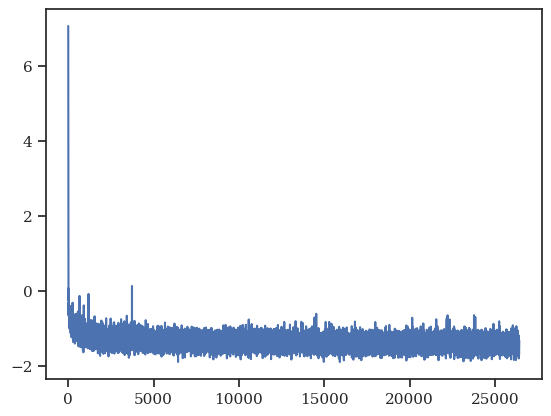

In [20]:
# Training
doubt_space = {
    "controller": {
        "type": "categorical",
        "number_of_classes": 3,
        "values": training_controller,
    },
    "speed": {
        "type": "continuous",
        "values": training_speed,
    },
}

doubt_density = DoubtDensity(
    doubt_space=doubt_space, number_of_states=2, number_of_hidden_features=100, number_of_layers=5
)

number_of_epochs = 20
batch_size = 100
losses = doubt_density.fit(training_xy, doubt_space, number_of_epochs, batch_size)

plt.plot(range(len(losses)), losses)
plt.show()

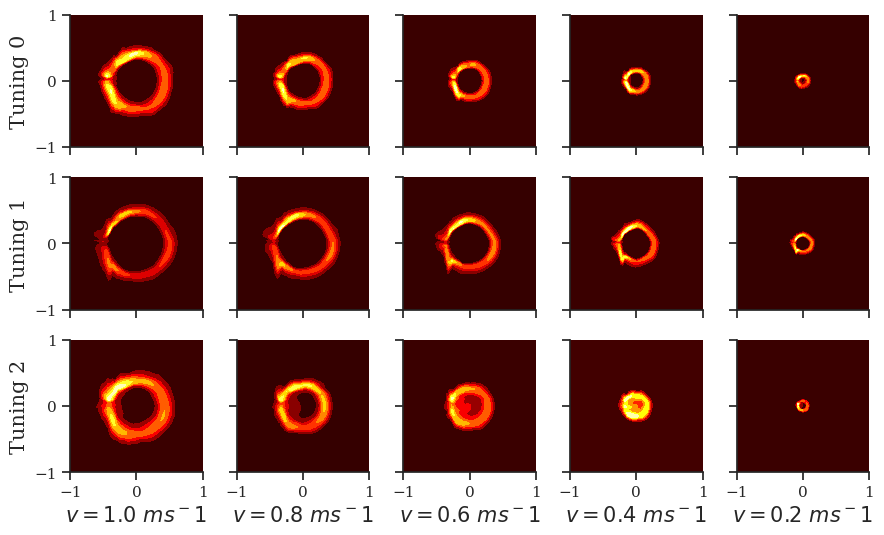

In [ ]:
# Visualization
fig, ax = plt.subplots(3, 5, figsize=(9, 5.5), sharex=True, sharey=True)
for time_index, speed in enumerate(trained_speeds):
    ax[2, time_index].set_xlabel(rf"$v = {speed}\ ms^{-1}$", fontsize=15)

for controller_index, tuning in enumerate(tunings):
    for time_index, speed in enumerate(trained_speeds):
        axis = ax[controller_index, time_index]
        axis.set_aspect(1)
        axis.set_yticks([-1, 0, 1])
        axis.set_xticks([-1, 0, 1])

        if time_index == 0:
            axis.set_ylabel(f"Tuning {controller_index}", fontsize=15)

        resolution = 250
        xline = torch.linspace(-1.0, 1.0, resolution)
        yline = torch.linspace(-1.0, 1.0, resolution)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing="xy")
        states = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            doubt_space["speed"]["values"] = torch.tensor([speed] * resolution * resolution)[
                :, None
            ]
            doubt_space["controller"]["values"] = torch.tensor(
                [controller_index] * resolution * resolution
            )[:, None]
            density = doubt_density.prob(states, doubt_space).reshape(resolution, resolution)

        axis.contourf(xgrid.numpy(), ygrid.numpy(), density.numpy(), cmap="hot")

sns.despine()
plt.tight_layout()
plt.subplots_adjust(
    wspace=0.1,
    hspace=0.1,
)
plt.savefig("doubt_density.pdf")
plt.show()

## Model the environment using StaRMap / ProMis

In [14]:
# Covariance matrices for some of the features
# Used to draw random translations representing uncertainty for the respective features
pos_std = 50  # millimeters
covariance = {
    "red": pos_std**2 * eye(2),
    "green": pos_std**2 * eye(2),
    "blue": pos_std**2 * eye(2),
    "yellow": pos_std**2 * eye(2),
}


# The probabilistic, logical constraints to fulfill during a mission
def logic(speed: float) -> str:
    return rf"""
    % Perception from sensors
    velocity ~ normal({speed}, 0.1).

    % Background knowledge
    rule_1(X) :- \+ over(X, red).
    rule_2(X) :- distance(X, yellow) > 50.
    rule_3(X) :- \+ over(X, green); velocity < 0.8.

    % Compliance with Constitution P(C | x, z)
    landscape(X) :- rule_1(X), rule_2(X), rule_3(X).
    """


# The mission area, points that will be estimated from 25 samples and points that will be interpolated
origin = PolarLocation(latitude=0.0, longitude=0.0)  # Irrelevant for Cartesian maps
number_of_random_maps = 25
support = CartesianRasterBand(
    origin, (300, 300), field_width_mm, field_height_mm
)  # This is the set of points that will be directly computed through sampling (expensive)
target = CartesianRasterBand(
    origin, (300, 300), field_width_mm, field_height_mm
)  # This is the set of points that will be interpolated from the support set (cheap)

uam = CartesianMap(origin, map_features)
uam.apply_covariance(covariance)  # Assigns the covariance matrices defined earlier

landscape_path = Path("data/virtual_setup_landscape.pkl")
if False:  # landscape_path.exists():
    landscape = CartesianCollection.load(landscape_path)

else:
    # Setting up the probabilistic spatial relations from the map data
    star_map = StaRMap(target, uam)
    # This estimates all spatial relations that are relevant to the given logic
    concrete_logic = logic(speed=0.25)
    star_map.initialize(support, number_of_random_maps, concrete_logic)
    star_map.save("data/virtual_setup_star_map.pkl")

    # Solve the mission area with ProMis
    promis = ProMis(star_map)
    landscape = promis.solve(support, concrete_logic, n_jobs=4, batch_size=8, show_progress=True)
    landscape.save(landscape_path)

star_map = StaRMap.load("data/virtual_setup_star_map.pkl")

Output()

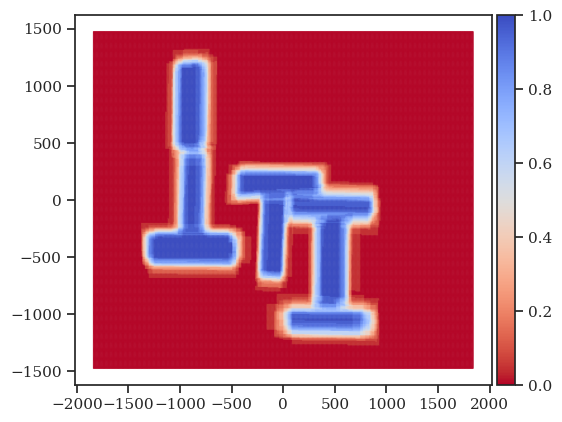

In [15]:
coollection = star_map.get("over", "red").parameters
img = coollection.scatter(
    value_index=0,
    plot_basemap=False,
    rasterized=True,
    cmap="coolwarm_r",
    s=0.25,
)
cbar = plt.colorbar(img, pad=0.01)
plt.show()

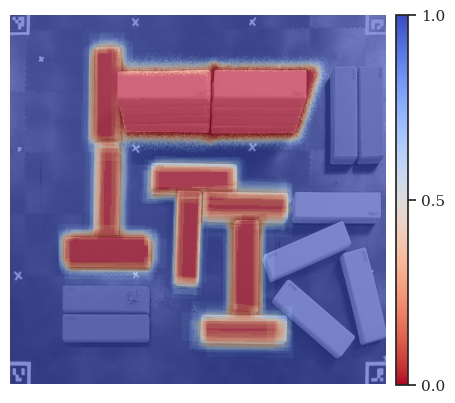

In [16]:
plt.imshow(
    scene_image.convert("L"),
    cmap="gray",
    extent=landscape.extent(),
    rasterized=True,
)
# image = landscape.scatter(
#     plot_basemap=False,
#     ax=plt.gca(),
#     rasterized=True,
#     cmap="coolwarm_r",
#     alpha=0.6,
#     s=0.15,
#     vmin=0,
#     vmax=1,
# )
image = plt.imshow(
    landscape.values().reshape(landscape.resolution)[::-1, :],
    extent=landscape.extent(),
    cmap="coolwarm_r",
    alpha=0.6,
    vmin=0,
    vmax=1,
    rasterized=True,
)
cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=30, pad=0.02)
cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
cbar.solids.set(alpha=1)

# plt.title("P(mission_landscape)")
# plt.xlabel("x / m")
# plt.ylabel("y / m")
# ticks = [-1_500, 0, 1_500]
# labels = ["-1.5", "0", "1.5"]
# plt.xticks(ticks, labels)
# plt.yticks(ticks, labels)
# plt.xlim([-1_850, 1_850])
# plt.ylim([-1_500, 1_500])

plt.gca().set_aspect(scene_image.width / scene_image.height, adjustable="box")
plt.gca().set_xticks([])
plt.gca().set_yticks([])
sns.despine(bottom=True, left=True)

plt.savefig("drone_landscape_high_speed.pdf", bbox_inches="tight")
plt.show()

## Adjust the landscape using the doubt & plan paths for experiments

Output()

Process SpawnPoolWorker-7:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-5:
Traceback (most recent call last):


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ~~~~^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/felix/Documents/phd/projects/ProMis/pr

KeyboardInterrupt: 

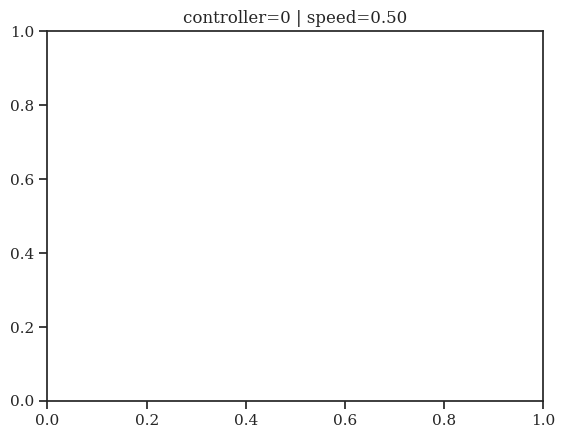

In [17]:
# Load the landscape produced by promis.ipynb and init CoCo
landscape = CartesianCollection.load("data/landscape.pkl")
coco = ConstitutionalController()

Path("data/drone-exp").mkdir(exist_ok=True)

landscapes = {}

# Select different doubt feature values, here we have just one feature velocity
# and use it directly as doubt density parameter
for controller in [0, 1, 2]:
    start = (-1_000, -1_000)
    goal = (1_400, 1_400)

    min_speed = 0.3
    max_speed = 1.4

    speeds = [0.5, 0.8, 1.2]
    start_speed = speeds[0]
    end_speed = speeds[0]

    # Only comes from the speed component
    min_cost = min_speed / max_speed  # All speed costs are scaled to this anyway
    vertical_weight = min_cost

    augmented_graphs: list[Graph] = []
    for speed in speeds:
        plt.title(f"controller={controller} | speed={speed:.2f}")

        def cost_model(p):
            consitution_cost = (1.0 - p) * 2
            time_cost = min_speed / speed
            return consitution_cost + time_cost

        def value_filter(p):
            return p >= min_cost

        # Compute the landscape
        try:
            landscape = landscapes[speed]
            path_wo_doubt = np.load(f"data/drone-exp/original_path-speed-{speed:.2f}.npy")
        except KeyError:
            promis = ProMis(star_map)
            landscape = promis.solve(
                support, logic(speed=speed), n_jobs=4, batch_size=8, show_progress=True
            )
            landscapes[speed] = landscape

            # Save the landscape for later use
            landscape.save(f"data/drone-exp/original_landscape-speed-{speed:.2f}.pkl")

            # Search for a path
            path_wo_doubt = landscape.search_path(
                start, goal, cost_model=cost_model, value_filter=value_filter, min_cost=min_cost
            )
            np.save(f"data/drone-exp/original_path-speed-{speed:.2f}.npy", path_wo_doubt)

        # Then express doubt
        ds = deepcopy(doubt_space)
        ds["controller"]["values"] = torch.tensor([[controller]])
        ds["speed"]["values"] = torch.tensor([[speed]])
        augmented_landscape: CartesianRasterBand = coco.apply_doubt(
            landscape=landscape,
            doubt_density=doubt_density,
            doubt_space=ds,
            number_of_samples=100,
        )
        augmented_landscape.save(
            f"data/drone-exp/augmented_landscape-controller-{controller}-speed-{speed:.2f}.pkl"
        )

        # Turn into a graph and save it
        augmented_graph = augmented_landscape.to_graph(
            cost_model=cost_model, value_filter=value_filter
        )
        with open(
            f"data/drone-exp/augmented_graph-controller-{controller}-speed-{speed:.2f}.pkl", "wb"
        ) as f:
            dump(augmented_graph, f)
        augmented_graphs.append(augmented_graph)

        # Plot the landscape
        image = augmented_landscape.scatter(
            s=0.4, plot_basemap=False, rasterized=True, cmap="coolwarm_r", alpha=0.25
        )
        cbar = plt.colorbar(image, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
        cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
        cbar.solids.set(alpha=1)

        # Search for a path
        path = augmented_landscape.search_path(
            start, goal, cost_model=cost_model, value_filter=value_filter, min_cost=min_cost
        )
        np.save(
            f"data/drone-exp/augmented_graph-controller-{controller}-speed-{speed:.2f}.npy", path
        )

        # Plot the path
        scatter = plt.scatter(
            [n[0] for n in path_wo_doubt],
            [n[1] for n in path_wo_doubt],
            s=1,
            c="black",
            vmin=0,
            vmax=1,
        )
        scatter = plt.scatter(
            [n[0] for n in path],
            [n[1] for n in path],
            s=1,
            c=[
                coco.compliance(
                    path=path,
                    landscape=augmented_landscape,
                    doubt_density=doubt_density,
                    doubt_space=doubt_space,
                    number_of_samples=100,
                )
            ],
            vmin=0,
            vmax=1,
            cmap="berlin",
        )
        cbar = plt.colorbar(scatter, ticks=[0.0, 0.5, 1.0], aspect=25, pad=0.02)
        cbar.ax.set_yticklabels(["0.0", "0.5", "1.0"])
        cbar.solids.set(alpha=1)

        # plt.gca().set_aspect(scene_image.width / scene_image.height, adjustable="box")
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        sns.despine(bottom=True, left=True)

        plt.show()

    extended_graph = CartesianRasterBand.stack_graphs(
        augmented_graphs, labels=[s for s in speeds], vertical_weight=vertical_weight
    )
    with open(f"data/drone-exp/extended_graph-controller-{controller}.pkl", "wb") as f:
        dump(extended_graph, f)

    path = augmented_landscape.search_path(  # sic
        (*start, start_speed),
        (*goal, end_speed),
        graph=extended_graph,
        cost_model=cost_model,
        value_filter=value_filter,
        min_cost=min_cost,
    )
    np.save(f"data/drone-exp/extended_path-controller-{controller}.npy", path)